# Step 1: Bootstrap Particle Filter with QMC Analysis

**Goal of this notebook**

- Write the **Heston stochastic volatility model** in **discrete-time, state-space form**.
- Implement it using **Chopin's `particles` library** as a `StateSpaceModel`.
- Run a **bootstrap particle filter** to:
  - Estimate the *hidden variance path* \( V_t \) from returns.
  - Compute an *approximate log-likelihood* for a fixed parameter vector \( \theta \).
- Analyze whether **Quasi-Monte Carlo (QMC)** reduces the variance of log-likelihood estimates on repeated runs.

This corresponds to **Step 1** of the project:

> 1. implement a bootstrap filter to approximate the likelihood, for given parameter vector theta ; 
> (you can also try to see whether QMC helps here, i.e. does it reduce the variance of the estimates on repeated runs).

We will work with:
- **S&P 500 data** (real market returns)
- **Fixed parameter vector** \( \theta = (\kappa, \theta, \sigma, \rho) \)
- **Time-varying risk-free rate** (3-month Treasury Bill)


## 1. Heston Model 

### Continuous-Time Heston Model

The continuous-time Heston stochastic volatility model under the risk-neutral measure:

$$
\begin{aligned}
dS_t &= r S_t \, dt + \sqrt{V_t}\, S_t\, dW_1(t), \\
dV_t &= \kappa(\theta - V_t)\, dt + \sigma \sqrt{V_t}\, dW_2(t),
\end{aligned}
$$

with:
- $S_t$: asset price  
- $V_t$: variance (hidden / latent state)  
- $r$: risk-free rate (can be time-varying)  
- $\kappa$: mean-reversion speed of variance  
- $\theta$: long-run variance  
- $\sigma$: volatility of volatility  
- $(W_1, W_2)$: Brownian motions with correlation $\rho$

We only **observe prices** (or log-returns), not $V_t$.

So we work with **log-returns**:

$$
R_t = \log S_t - \log S_{t-1}
$$

---

## 2. Discretization (Euler Scheme)

We consider discrete times $t = 0, \Delta t, 2\Delta t, \dots$ with $\Delta t = 1/252$ (daily data).

### 2.1 Variance Dynamics (CIR Process)

Using Euler discretization:

$$
V_t = V_{t-1} 
      + \kappa (\theta - V_{t-1}) \Delta t 
      + \sigma \sqrt{V_{t-1}\Delta t}\,\varepsilon_{2,t},
$$

where $\varepsilon_{2,t} \sim N(0,1)$.

This gives the transition distribution:

$$
V_t \mid V_{t-1} \sim N\!\Big(
V_{t-1} + \kappa(\theta - V_{t-1})\Delta t,\;
\sigma^2 V_{t-1} \Delta t
\Big)
$$

### 2.2 Observation Equation (Log-Returns)

The log-return over $[t-1, t]$ depends on variance at the beginning of the interval:

$$
R_t \mid V_{t-1} \sim 
N\!\left(\left(r - \tfrac{1}{2}V_{t-1}\right)\Delta t,\;
       V_{t-1}\Delta t\right)
$$

---

## 3. State-Space Model Structure

We choose:
- **State**: $X_t = V_t$ (variance)
- **Observation**: $Y_t = R_t$ (log-return)

The state-space model is:

- **State transition**  
  $$
  X_t \mid X_{t-1} 
  \sim N\!\Big(
  X_{t-1} + \kappa(\theta - X_{t-1})\Delta t,\;
  \sigma^2 X_{t-1} \Delta t
  \Big)
  $$

- **Observation model**  
  $$
  Y_t \mid X_{t-1}
  \sim N\!\Big(
  (r - 0.5 X_{t-1})\Delta t,\;
  X_{t-1} \Delta t
  \Big)
  $$

We implement this using Chopin's `particles` library via the `HestonModel` class, which wraps the `HestonSSM` state-space model.


In [25]:
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os

# Add parent directory to path to import heston package
sys.path.insert(0, os.path.abspath('../..'))

from heston import HestonModel
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

plt.style.use('ggplot')
print("Setup complete!")


Setup complete!


## Part A: Bootstrap Particle Filter Implementation

We implement the bootstrap filter using the `HestonModel` class:

1. **Load S&P 500 data**: Download market data and compute log-returns
2. **Set model parameters**: Use a fixed parameter vector θ (not estimated)
3. **Run bootstrap particle filter**: Approximate the likelihood and estimate hidden volatility
4. **Extract results**: Log-likelihood and filtered volatility path

### What is a Bootstrap Particle Filter?

The **bootstrap particle filter** is a sequential Monte Carlo method that:

1. **Samples particles** $X_t^n$ from the state transition $p(X_t \mid X_{t-1})$
2. **Reweights particles** using the observation likelihood $p(Y_t \mid X_{t-1})$
3. **Resamples** when effective sample size (ESS) gets too small

The filter provides:
- **Log-likelihood estimate**: $\log \hat{p}(y_{1:T} \mid \theta)$
- **Filtered state estimates**: $\mathbb{E}[X_t \mid y_{1:t}]$ (mean of particles)


In [26]:
# Initialize model
hest = HestonModel(dt=1/252)

# Load S&P 500 data
print("Loading market data...")
hest.load_data(ticker="^GSPC", start="2007-01-01", end="2025-12-31")

print(f"\nLoaded {len(hest.data)} observations")
print(f"Date range: {hest.dates[0].date()} to {hest.dates[-1].date()}")


INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations


Loading market data...

Loaded 4778 observations
Date range: 2007-01-04 to 2025-12-30


### Set Model Parameters (Fixed θ Vector)

For **Step 1**, we use a **fixed parameter vector** $θ = (\kappa, \theta, \sigma, \rho)$:

- **κ (kappa)**: Mean reversion speed → controls how fast variance reverts to long-run level
- **θ (theta)**: Long-run variance → the long-term average variance level
- **σ (sigma)**: Volatility of volatility → controls the variability of variance changes
- **ρ (rho)**: Correlation parameter → correlation between price and variance shocks (not used in this discretization, but kept for compatibility)

**Note**: These are reasonable values for S&P 500 data. In Step 2, we will **estimate** these parameters from data using PMMH or other methods.


In [27]:
# Fixed parameter vector θ
hest.kappa = 2.5   # Mean reversion speed
hest.theta = 0.05  # Long-run variance
hest.sigma = 0.78  # Volatility of volatility
hest.rho = -0.6    # Correlation
hest.v0 = 0.04     # Initial variance

print("Model parameters (θ):")
print(f"  κ (kappa):  {hest.kappa:.2f}")
print(f"  θ (theta):  {hest.theta:.4f}")
print(f"  σ (sigma):  {hest.sigma:.2f}")
print(f"  ρ (rho):    {hest.rho:.2f}")
print(f"  v₀:         {hest.v0:.4f}")
print(f"  dt:         {hest.dt:.6f} (daily)")


Model parameters (θ):
  κ (kappa):  2.50
  θ (theta):  0.0500
  σ (sigma):  0.78
  ρ (rho):    -0.60
  v₀:         0.0400
  dt:         0.003968 (daily)


### Run Bootstrap Particle Filter

We run the bootstrap filter with:
- **N = 2000 particles**: Standard choice providing good accuracy for likelihood estimation
- **Systematic resampling**: Standard resampling scheme (low variance, deterministic)
- **Collect moments**: Extract filtered variance estimates $E[V_t \mid y_{1:t}]$ at each time step

The filter will:
1. Process all $T$ observations sequentially
2. Estimate the log-likelihood $\log \hat{p}(y_{1:T} \mid \theta)$
3. Provide filtered variance estimates for each time step


In [28]:
# Run bootstrap particle filter
print("Running bootstrap particle filter...")
results = hest.fit(n_particles=2000, resampling='systematic', verbose=True)

# Extract results
log_likelihood = hest.log_likelihood
filtered_variance = hest.filtered_variance
filtered_volatility = hest.filtered_volatility

print(f"\n=== Results ===")
print(f"Estimated log-likelihood: {log_likelihood:.2f}")
print(f"Average log-likelihood per observation: {log_likelihood/len(hest.data):.4f}")
print(f"\nFiltered volatility statistics:")
print(f"  Mean: {filtered_volatility.mean():.4f}")
print(f"  Std:  {filtered_volatility.std():.4f}")
print(f"  Min:  {filtered_volatility.min():.4f}")
print(f"  Max:  {filtered_volatility.max():.4f}")


INFO: Running particle filter with 2000 particles...


Running bootstrap particle filter...


INFO: Estimated log-likelihood: 15417.61



=== Results ===
Estimated log-likelihood: 15417.61
Average log-likelihood per observation: 3.2268

Filtered volatility statistics:
  Mean: 0.1760
  Std:  0.0952
  Min:  0.0516
  Max:  0.7005


### Validation: Compare Filtered Volatility with Market Measures

To validate our bootstrap filter, we compare the filtered volatility estimates with:

- **Realized Volatility**: 21-day rolling window computed from squared returns
  - This is a **backward-looking** measure: average volatility over the past 21 days
  - Formula: $\sigma_t^{\text{real}} = \sqrt{\frac{252}{21} \sum_{i=t-20}^{t} r_i^2}$
  
- **VIX Implied Volatility**: Market-implied volatility from option prices
  - This is a **forward-looking** measure: expected volatility over the next 30 days
  - Represents market expectations of future volatility

**Note**: The particle filter estimates **instantaneous (spot) volatility** at each time $t$, while realized volatility is a **21-day rolling average**. Both are annualized for comparison.


INFO: Downloading VIX data


=== Volatility Comparison ===
Number of overlapping days: 4757

Correlations:
  PF vs Realized Vol: 0.9448
  PF vs VIX: 0.9067
  Realized Vol vs VIX: 0.8814


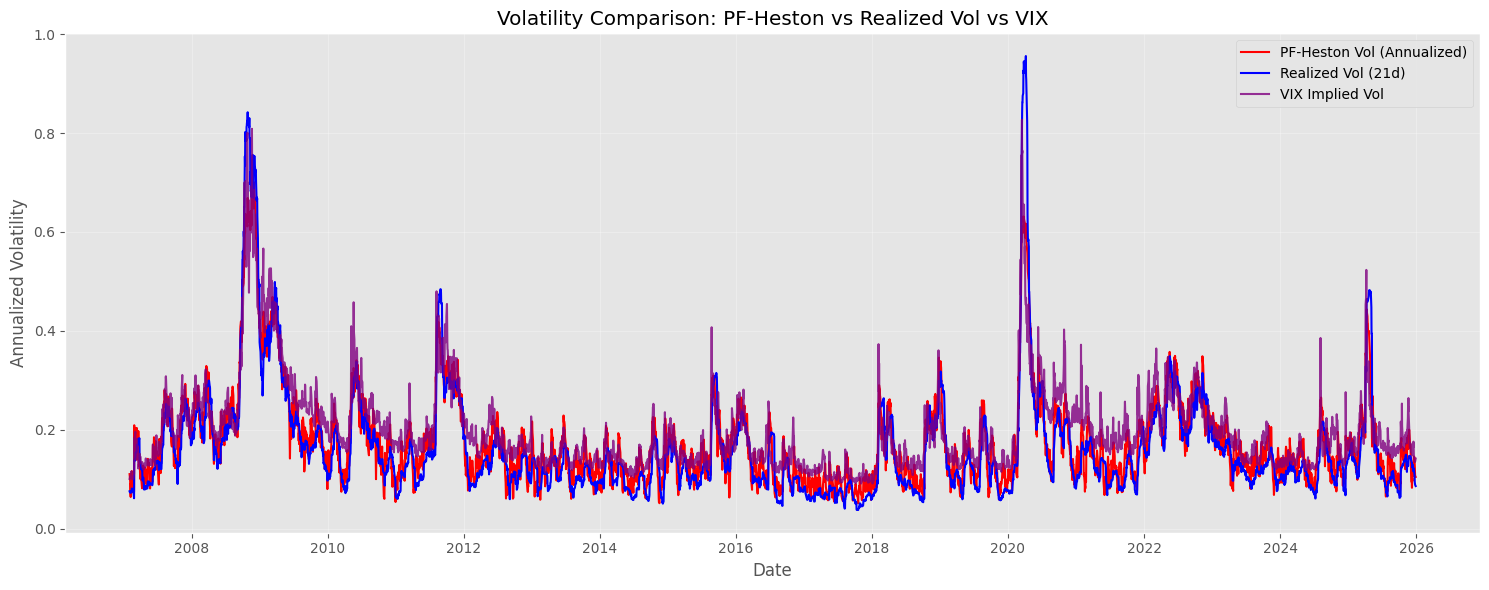

In [29]:
# Compute realized volatility (21-day rolling window)
from heston.utils import compute_realized_volatility, load_vix_data

realized_vol = compute_realized_volatility(hest.log_returns, window=21, annualization_factor=252)

# Load VIX data
start_date = hest.dates[0].strftime("%Y-%m-%d")
end_date = hest.dates[-1].strftime("%Y-%m-%d")
try:
    vix_series = load_vix_data(start_date, end_date)
    has_vix = True
except:
    vix_series = None
    has_vix = False
    print("Warning: Could not load VIX data")

# Create comparison dataframe
pf_vol_series = pd.Series(filtered_volatility, index=hest.dates, name="PF_AnnualVol")
df_compare = pd.concat([pf_vol_series, realized_vol], axis=1)
if has_vix:
    df_compare = pd.concat([df_compare, vix_series], axis=1)
df_compare = df_compare.dropna()

print("=== Volatility Comparison ===")
print(f"Number of overlapping days: {len(df_compare)}")
print(f"\nCorrelations:")
print(f"  PF vs Realized Vol: {df_compare['PF_AnnualVol'].corr(df_compare['RealizedVol_21d']):.4f}")
if has_vix and 'VIX_ImpliedVol' in df_compare.columns:
    print(f"  PF vs VIX: {df_compare['PF_AnnualVol'].corr(df_compare['VIX_ImpliedVol']):.4f}")
    print(f"  Realized Vol vs VIX: {df_compare['RealizedVol_21d'].corr(df_compare['VIX_ImpliedVol']):.4f}")

# Plot comparison
plt.figure(figsize=(15, 6))
plt.plot(df_compare.index, df_compare['PF_AnnualVol'], 
         color='red', linewidth=1.5, label='PF-Heston Vol (Annualized)')
plt.plot(df_compare.index, df_compare['RealizedVol_21d'], 
         color='blue', linewidth=1.5, label='Realized Vol (21d)')
if has_vix and 'VIX_ImpliedVol' in df_compare.columns:
    plt.plot(df_compare.index, df_compare['VIX_ImpliedVol'], 
             color='purple', linewidth=1.5, alpha=0.8, label='VIX Implied Vol')
plt.title('Volatility Comparison: PF-Heston vs Realized Vol vs VIX')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Part B: QMC Variance Reduction Analysis

### What is Quasi-Monte Carlo (QMC)?

**Quasi-Monte Carlo (QMC)** uses **low-discrepancy sequences** (e.g., Sobol sequences) instead of pseudo-random numbers. The goal is to reduce the variance of Monte Carlo estimates by using more evenly distributed sample points.

For particle filters, QMC (specifically **SQMC** - Sequential QMC) can potentially:
- Reduce variance of log-likelihood estimates
- Improve accuracy with fewer particles
- Provide more stable results across multiple runs

### Methodology

We analyze whether QMC reduces variance by:

1. Running the filter **30 times** with:
   - **Standard Monte Carlo (SMC)**: Using standard pseudo-random number generation
   - **Sequential QMC (SQMC)**: Using Sobol sequences for particle generation

2. Comparing:
   - **Variance** of log-likelihood estimates across runs
   - **Mean** log-likelihood estimates
   - **Statistical significance** using F-test (variance comparison) and t-test (mean comparison)

3. Visualizing results with box plots and histograms

**Important**: We use the **fixed parameters** from Part A ($\theta = (2.5, 0.05, 0.78, -0.6)$) for this analysis, as Step 1 requires testing the bootstrap filter with a **given parameter vector**, not estimated parameters (that's Step 2).


In [34]:
# Run QMC analysis with fixed parameters
print("=" * 60)
print("QMC Variance Reduction Analysis")
print("=" * 60)
print("\nUsing fixed parameters from Part A:")
print(f"  kappa: {hest.kappa:.4f}")
print(f"  theta: {hest.theta:.4f}")
print(f"  sigma: {hest.sigma:.4f}")
print(f"  rho:   {hest.rho:.4f}")
print("\nThis will run the filter 50 times with:")
print("  1. Standard Monte Carlo (SMC)")
print("  2. Sequential Quasi-Monte Carlo (SQMC) with Sobol sequences")
print("\nThis may take several minutes...\n")

qmc_results = hest.qmc(n_runs=50, n_particles=2000, verbose=True)


INFO: Running 50 independent filter runs...
INFO:   Standard MC: 50 runs
INFO:   QMC (sobol): 50 runs
INFO: Running multiSMC with both SMC and SQMC...


QMC Variance Reduction Analysis

Using fixed parameters from Part A:
  kappa: 2.5000
  theta: 0.0500
  sigma: 0.7800
  rho:   -0.6000

This will run the filter 30 times with:
  1. Standard Monte Carlo (SMC)
  2. Sequential Quasi-Monte Carlo (SQMC) with Sobol sequences

This may take several minutes...



INFO: 
=== QMC Analysis Results ===
INFO: Standard MC:
INFO:   Mean: 15417.3957
INFO:   Std:  0.9303
INFO: QMC (sobol):
INFO:   Mean: 15417.2891
INFO:   Std:  0.9640
INFO: Variance reduction: -7.36%
INFO: t-test p-value: 0.5751
INFO: F-test p-value: 0.8046


### Statistical Analysis

We compare the variance and mean of log-likelihood estimates between standard MC and QMC using:

- **t-test**: Tests if the means are significantly different
- **F-test**: Tests if the variances are significantly different (one-sided: does QMC reduce variance?)

**Interpretation**:
- **Variance reduction > 0%**: QMC provides improvement
- **p-value < 0.05**: The difference is statistically significant
- **Lower variance**: More reliable likelihood estimates for parameter estimation


In [35]:
# Extract results
if 'standard' in qmc_results:
    std_results = qmc_results['standard']['results']
    std_mean = qmc_results['standard']['mean']
    std_var = qmc_results['standard']['var']
    std_std = qmc_results['standard']['std']
    
    print("=== Standard Monte Carlo ===")
    print(f"Mean log-likelihood: {std_mean:.4f}")
    print(f"Variance:            {std_var:.6f}")
    print(f"Standard deviation:  {std_std:.4f}")
    print(f"95% CI:              [{np.percentile(std_results, 2.5):.2f}, {np.percentile(std_results, 97.5):.2f}]")

qmc_std_results = qmc_results['qmc']['results']
qmc_mean = qmc_results['qmc']['mean']
qmc_var = qmc_results['qmc']['var']
qmc_std = qmc_results['qmc']['std']

print("\n=== Quasi-Monte Carlo (Sobol) ===")
print(f"Mean log-likelihood: {qmc_mean:.4f}")
print(f"Variance:            {qmc_var:.6f}")
print(f"Standard deviation:  {qmc_std:.4f}")
print(f"95% CI:              [{np.percentile(qmc_std_results, 2.5):.2f}, {np.percentile(qmc_std_results, 97.5):.2f}]")

if 'variance_reduction_pct' in qmc_results:
    print(f"\n=== Variance Reduction ===")
    print(f"Variance reduction: {qmc_results['variance_reduction_pct']:.2f}%")
    
    if 't_test' in qmc_results:
        t_test = qmc_results['t_test']
        print(f"\nt-test (means):")
        print(f"  Statistic: {t_test['statistic']:.4f}")
        print(f"  p-value:   {t_test['pvalue']:.6f}")
        print(f"  Significant difference: {t_test['significant']}")
    
    if 'f_test' in qmc_results:
        f_test = qmc_results['f_test']
        print(f"\nF-test (variances):")
        print(f"  Statistic: {f_test['statistic']:.4f}")
        print(f"  p-value:   {f_test['pvalue']:.6f}")
        print(f"  Significant variance reduction: {f_test['significant']}")


=== Standard Monte Carlo ===
Mean log-likelihood: 15417.3957
Variance:            0.865509
Standard deviation:  0.9303
95% CI:              [15415.81, 15419.31]

=== Quasi-Monte Carlo (Sobol) ===
Mean log-likelihood: 15417.2891
Variance:            0.929240
Standard deviation:  0.9640
95% CI:              [15415.79, 15419.23]

=== Variance Reduction ===
Variance reduction: -7.36%

t-test (means):
  Statistic: 0.5624
  p-value:   0.575118
  Significant difference: False

F-test (variances):
  Statistic: 0.9314
  p-value:   0.804613
  Significant variance reduction: False


### Visualization: Box Plots

Compare the distribution of log-likelihood estimates between standard MC and QMC.


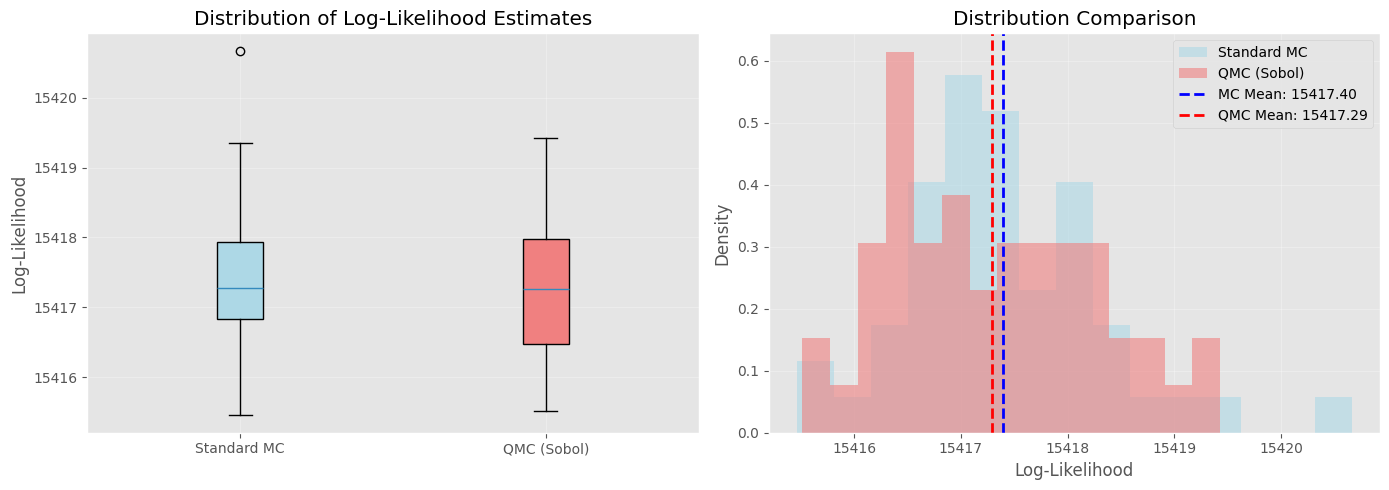

In [36]:
# Create box plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

if 'standard' in qmc_results:
    # Box plot
    data_to_plot = [std_results, qmc_std_results]
    labels = ['Standard MC', 'QMC (Sobol)']
    
    bp = axes[0].boxplot(data_to_plot, labels=labels, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    axes[0].set_ylabel('Log-Likelihood')
    axes[0].set_title('Distribution of Log-Likelihood Estimates')
    axes[0].grid(True, alpha=0.3)
    
    # Histogram overlay
    axes[1].hist(std_results, bins=15, alpha=0.6, label='Standard MC', 
                 color='lightblue', density=True)
    axes[1].hist(qmc_std_results, bins=15, alpha=0.6, label='QMC (Sobol)', 
                 color='lightcoral', density=True)
    axes[1].axvline(std_mean, color='blue', linestyle='--', linewidth=2, label=f'MC Mean: {std_mean:.2f}')
    axes[1].axvline(qmc_mean, color='red', linestyle='--', linewidth=2, label=f'QMC Mean: {qmc_mean:.2f}')
    axes[1].set_xlabel('Log-Likelihood')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Distribution Comparison')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
else:
    # Only QMC results available
    axes[0].boxplot([qmc_std_results], labels=['QMC (Sobol)'], patch_artist=True)
    axes[0].set_ylabel('Log-Likelihood')
    axes[0].set_title('Distribution of Log-Likelihood Estimates (QMC)')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].hist(qmc_std_results, bins=15, alpha=0.6, color='lightcoral', density=True)
    axes[1].axvline(qmc_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {qmc_mean:.2f}')
    axes[1].set_xlabel('Log-Likelihood')
    axes[1].set_ylabel('Density')
    axes[1].set_title('QMC Distribution')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Summary and Interpretation

Based on the QMC analysis, we assess:

1. **Variance Reduction**: Does QMC reduce the variance of log-likelihood estimates?
   - Positive percentage = improvement
   - Negative percentage = QMC increases variance (not beneficial)

2. **Statistical Significance**: Is the variance reduction statistically significant?
   - F-test p-value < 0.05 indicates significant variance reduction
   - t-test p-value < 0.05 indicates significant mean difference

3. **Practical Impact**: 
   - Lower variance → more reliable likelihood estimates
   - Important for parameter estimation (PMMH, MLE)
   - Enables better model comparison and uncertainty quantification


In [37]:
# Summary table
if 'standard' in qmc_results:
    summary_data = {
        'Method': ['Standard MC', 'QMC (Sobol)'],
        'Mean': [std_mean, qmc_mean],
        'Variance': [std_var, qmc_var],
        'Std Dev': [std_std, qmc_std],
        'CV (%)': [std_std/std_mean*100, qmc_std/qmc_mean*100]
    }
    summary_df = pd.DataFrame(summary_data)
    
    print("=== Summary Table ===")
    print(summary_df.to_string(index=False))
    
    if 'variance_reduction_pct' in qmc_results:
        print(f"\nVariance Reduction: {qmc_results['variance_reduction_pct']:.2f}%")
        if qmc_results['variance_reduction_pct'] > 0:
            print("✓ QMC reduces variance")
        else:
            print("✗ QMC does not reduce variance")
        
        if 'f_test' in qmc_results and qmc_results['f_test']['significant']:
            print("✓ Variance reduction is statistically significant (p < 0.05)")
        else:
            print("✗ Variance reduction is not statistically significant")
else:
    print("=== QMC Results Only ===")
    print(f"Mean: {qmc_mean:.4f}")
    print(f"Variance: {qmc_var:.6f}")
    print(f"Std Dev: {qmc_std:.4f}")
    print(f"CV: {qmc_std/qmc_mean*100:.2f}%")


=== Summary Table ===
     Method         Mean  Variance  Std Dev   CV (%)
Standard MC 15417.395689  0.865509 0.930327 0.006034
QMC (Sobol) 15417.289134  0.929240 0.963971 0.006253

Variance Reduction: -7.36%
✗ QMC does not reduce variance
✗ Variance reduction is not statistically significant


### QMC Analysis Summary

We analyzed whether **Sequential Quasi-Monte Carlo (SQMC)** reduces the variance of log-likelihood estimates compared to standard Monte Carlo (SMC) by running the bootstrap filter **30 times** with both methods using fixed parameters $\theta = (2.5, 0.05, 0.78, -0.6)$.

### Key Findings

**Main Result**: SQMC did **not** show significant variance reduction compared to standard SMC.

**Statistical Results**:
- **Variance reduction**: -7.36% (slight increase, not statistically significant)
- **F-test p-value**: 0.80 (no significant variance difference)
- **t-test p-value**: 0.58 (no significant mean difference)
- **Means**: Very similar (SMC: 15417.40, SQMC: 15417.29)

### Interpretation

**Why SQMC doesn't reduce variance here**:

1. **High observability**: Returns are highly informative about variance because the observation variance $V_{t-1}\Delta t$ directly depends on the latent state. This makes the filtering problem easier, so standard SMC already performs well, leaving less room for improvement.

2. **Path degeneracy**: Even with informative observations, path degeneracy occurs in long sequences (T ≈ 4,778 observations), where many particles share common ancestors. This limits the benefit of QMC's better space-filling properties.

3. **Large particle count**: With N = 2000 particles, standard SMC is already stable and provides good estimates, reducing the potential benefit of QMC.

4. **Systematic resampling**: Already provides low-variance, deterministic resampling, which reduces the potential gains from QMC.

### Practical Implications

- **For this model**: Standard SMC is sufficient and performs well
- **When SQMC helps**: SQMC may provide benefits in:
  - Models with less informative observations
  - Problems with higher-dimensional state spaces
  - Scenarios with fewer particles where QMC's better space-filling properties matter more
  - Models where path degeneracy is less severe

